

Transient Scan ID: 1     Time: 2023-05-04 11:41:16
Persistent Unique Scan ID: '5dacbf58-1d23-4056-b84a-cdb083b84a62'
New stream: 'baseline'
Start-of-run baseline readings:
+--------------------------------+--------------------------------+
|                      noisy_det | 0.9962538225890805             |
+--------------------------------+--------------------------------+
we've be asked to complete
New stream: 'primary'
+-----------+------------+--------------+
|   seq_num |       time | my_det_count |
+-----------+------------+--------------+
|         1 | 11:41:17.0 |        46404 |
|         2 | 11:41:17.1 |        46404 |
|         3 | 11:41:17.1 |        46404 |
|         4 | 11:41:17.2 |        47584 |
|         5 | 11:41:17.2 |        47584 |
|         6 | 11:41:17.2 |        47584 |
|         7 | 11:41:17.2 |        47584 |
|         8 | 11:41:17.3 |        48741 |
|         9 | 11:41:17.3 |        48741 |
|        10 | 11:41:17.3 |        48741 |
|        11 | 11:41:17.3 | 

/home/emil/Apps/dev/sissy_profile_dev/.venv/lib/python3.8/site-packages/event_model/__init__.py:208: UserWarning: The document type 'bulk_events' has been deprecated in favor of 'event_page', whose structure is a transpose of 'bulk_events'.
  warnings.warn(


+-----------+------------+--------------+
generator flycount ['5dacbf58'] (scan num: 1)
End-of-run baseline readings:
+--------------------------------+--------------------------------+
|                      noisy_det | 1.0595349296388594             |
+--------------------------------+--------------------------------+





('5dacbf58-1d23-4056-b84a-cdb083b84a62',)

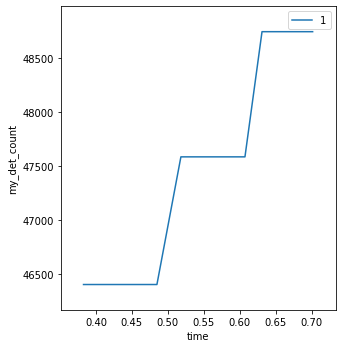

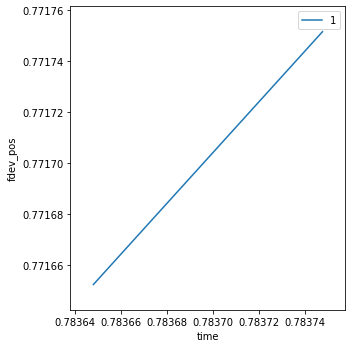

In [1]:
from bessyii.plans.flying import flycount, flyscan

from bessyii_devices.flyer import MyMotor, MyDetector, BasicFlyer
#Flyer Sim
my_det = MyDetector('EMILEL:TestIOC00:', name='my_det')
fdev = MyMotor('EMILEL:TestIOC00:', name='fdev')
fdev.wait_for_connection()

# Example: nested runs
from ophyd.sim import det, flyer1, flyer2  # simulated hardware
from databroker.v2 import temp


from bluesky.plans import count
from bluesky.callbacks.best_effort import BestEffortCallback
import bluesky.preprocessors as bpp
import bluesky.plan_stubs as bps
from databroker import Broker
from event_model import RunRouter
from bluesky import RunEngine

RE = RunEngine({})
db = temp()
RE.subscribe(db.v1.insert)


def factory(name, doc):
    # Documents from each run is routed to an independent
    #   instance of BestEffortCallback
    bec = BestEffortCallback()
    return [bec], []

rr = RunRouter([factory])
RE.subscribe(rr)


from bluesky.preprocessors import SupplementalData
sd = SupplementalData()
RE.preprocessors.append(sd)

from ophyd.sim import noisy_det
sd.baseline = [noisy_det]



fdev.start_pos.put(1)
fdev.end_pos.put(1.1)
fdev.velocity.put(0.2)
RE(flycount([my_det],fdev))

    



In [6]:
energies = [10,11,12]
dwells = [1,2,3]

total = zip(energies,dwells)

print(list(total))

[(10, 1), (11, 2), (12, 3)]


In [7]:
import time
time.time()

1683201139.4795623

In [14]:
#list has 3 elemenets

#0,1,2

3%3

0

In [ ]:
## Create a modified flycount plan that allows us to specify different energies to move a motor to and 
# hold it there for a given period of time

from bluesky import plan_stubs as bps
from bluesky import preprocessors as bpp
from functools import partial
import numpy as np
import time

from bluesky.utils import (
    separate_devices,
    all_safe_rewind,
    Msg,
    ensure_generator,
    short_uid as _short_uid,
)

from ophyd import Signal

def energy_changing_flycount(detectors,flyer,mono,energies, *,delay=0,shutter=None, md=None):
    """
    read from detectors in a list while a flyer is running. Stop only when it completes

    Parameters
    ----------
    detectors : list
        list of 'readable' objects
    flyer : flyer object
    mono : a setable device
    energies : a list of tuples
        The values to set to and the delays to stay at that energy for in seconds
    [(400, 1), (410, 2), (440, 3)]
    delay : iterable or scalar, optional
        Time delay in seconds between successive readings; default is 0
    shutter : Device with open and close value attributes
        If defined, a shutter will be opened when the device complete's kickoff
    md : dict, optional
        metadata

    Notes
    ----

    """

    #Define the motor metadata (important for plotting)
    md = md or {}

    _md = {'detectors': [det.name for det in detectors],

           'plan_args': {'detectors': list(map(repr, detectors))},
           'flyer': flyer.name,
           'mono' : mono.name,
           'energies' : energies,
           'plan_name': 'flycount',
           'hints': {}
           }

    _md.update(md or {})
    
    
    _md['hints'].setdefault('dimensions', [(('time',), 'primary')])
    _md.update(md)
    
    @bpp.stage_decorator([flyer]+detectors)
    @bpp.run_decorator(md=_md)
    def inner_flycount():
    
        # Start the flyer and wait until it's reported that it's started
        yield from bps.kickoff(flyer, wait=True)

        # Get the status object that tells us when it's done
        complete_status = yield from bps.complete(flyer, wait=False)

        #Now open the shutter if it's defined
        if shutter:
            yield from bps.mov(shutter,shutter.open_value,wait=True)

        i = 0 #energy index
        num_energies = len(energies)
        while not complete_status.done:

            
            energy = energies[i%num_energies][0]
            #move to next energy
            yield from bps.mov(mono,energy,wait=True)
            
            #get the current time
            t0 = time.time()
            t_end = energies[i%num_energies][1] +t0

            while time.time()<t_end:
            

                yield Msg('checkpoint') # allows us to pause the run 
                yield from bps.one_shot(detectors) #triggers and reads everything in the detectors list
                yield Msg('sleep', None, delay)


            
            i = i+1
            
        yield from bps.collect(flyer)

        #Now close the shutter if it's defined
        if shutter:
            yield from bps.mov(shutter,shutter.close_value,wait=True)


    return (yield from inner_flycount())